# Two sides of the same coin: Beneficial and detrimental consequences of range adaptation in human reinforcement learning
This is my implementation of this paper, done with the purpose of understanding it in depth

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Range Model

Formula for calculating the relative reward

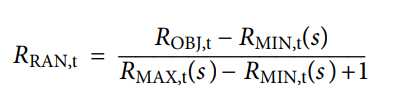

In [2]:
class Experiment:

    def __init__(self, option1=10, option2=10, probability1=75, probability2=25):
        self.options = [option1, option2]
        self.probabilities = [probability1, probability2]
    
    def rollReward(self, choice=0):
        """
        Choice has to be either 0 or 1.

        Returns either the reward or 0.
        """

        options = [self.options[choice], 0]
        probabilities = [self.probabilities[choice], 100 - self.probabilities[choice]]

        return random.choices(options, probabilities)[0] # Tengo que regresar las recompensas normalizadas

In [3]:
class Agent:
    
    def __init__(self, num_choices=2, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.q_values = np.zeros(num_choices)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.rMin = 0
        self.rMax = 0

    def select_action(self):
        if np.random.rand() < self.epsilon: # Explore
            return np.random.randint(len(self.q_values))
        else: # Exploit
            return np.argmax(self.q_values)
        
    def update_q_values(self, action, reward):
        self.q_values[action] = self.q_values[action] + self.learning_rate*(reward - self.q_values[action])

    def update_q_values_normalized(self, action, reward):
        # Normalize the reward
        self.rMin = min(self.rMin, reward)
        self.rMax = max(self.rMax, reward)
        reward = (reward - self.rMin) / (self.rMax - self.rMin + 1)
        
        self.q_values[action] = self.q_values[action] + self.learning_rate*(reward - self.q_values[action])

In [4]:
# Baseline comparision
baseline10Experiment = Experiment(10, 10, 75, 25) # Rewards of 10, with 75% and 25% probability respectively
baseline1Experiment = Experiment(1, 1, 75, 25) # Rewards of 1, with 75% and 25% probability respectively

r1, r2, r3, r4 = 0, 0, 0, 0

for i in range(1000):
    r1 += baseline10Experiment.rollReward(0)
    r2 += baseline10Experiment.rollReward(1)
    r3 += baseline1Experiment.rollReward(0)
    r4 += baseline1Experiment.rollReward(1)

print("10 with 75%:", r1)
print("10 with 25%:", r2)
print("1 with 75%:", r3)
print("1 with 25%:", r4)

10 with 75%: 7630
10 with 25%: 2340
1 with 75%: 741
1 with 25%: 231


In [5]:
def train_agent(episodes=1000, experiment=Experiment(10, 10, 75, 25), agent=Agent()):
    rewards = []
    avg_rewards = []

    for episode in range(episodes):
        action = agent.select_action()
        reward = experiment.rollReward(action)
        agent.update_q_values(action, reward)
        rewards.append(reward)
        avg_rewards.append(np.average(rewards))

    print('Q-table:', agent.q_values)

    return avg_rewards, agent.q_values

def train_agent_normalized(episodes=1000, experiment=Experiment(10, 10, 75, 25), agent=Agent()):
    rewards = []
    avg_rewards = []

    for episode in range(episodes):
        action = agent.select_action()
        reward = experiment.rollReward(action)
        agent.update_q_values_normalized(action, reward)
        rewards.append(reward)
        avg_rewards.append(np.average(rewards))

    print('Q-table:', agent.q_values)

    return avg_rewards, agent.q_values

Q-table: [7.19574382 0.92809169]


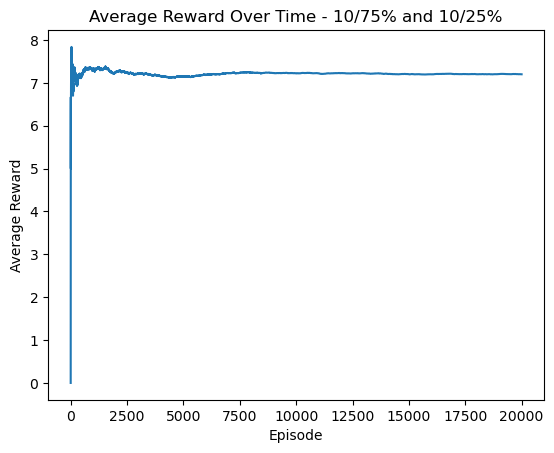

In [6]:
# Rewards of 10, with 75% and 25% probability respectively

experiment = Experiment(10, 10, 75, 25)
agent = Agent()
steps = 20000

avg_rewards, q_values1 = train_agent(steps, experiment, agent)

# Visualization

plt.plot(avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward Over Time - 10/75% and 10/25%')
plt.show()


Q-table: [0.76802889 0.20199192]


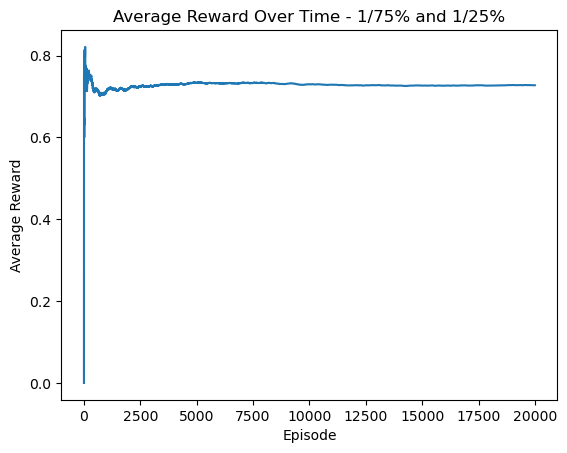

In [7]:
 # Rewards of 1, with 75% and 25% probability respectively

experiment = Experiment(1, 1, 75, 25)
agent = Agent()
steps = 20000

avg_rewards, q_values2 = train_agent(steps, experiment, agent)

# Visualization

plt.plot(avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward Over Time - 1/75% and 1/25%')
plt.show()


Q-table: [0.81738506 0.15644578]


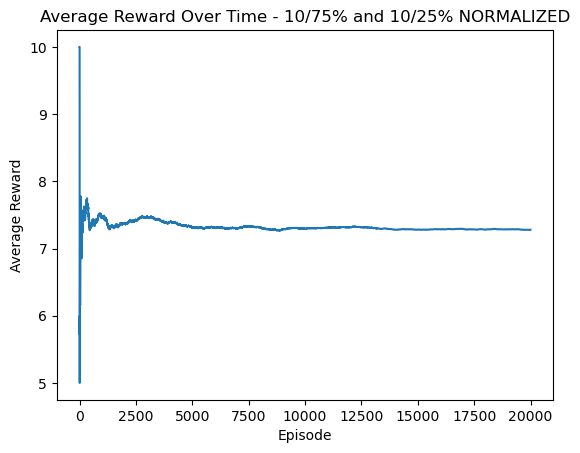

In [8]:
# Rewards of 10, with 75% and 25% probability respectively

experiment = Experiment(10, 10, 75, 25)
agent = Agent()
steps = 20000

avg_rewards, q_values1_norm = train_agent_normalized(steps, experiment, agent)

# Visualization

plt.plot(avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward Over Time - 10/75% and 10/25% NORMALIZED')
plt.show()


Q-table: [0.74751277 0.2663463 ]


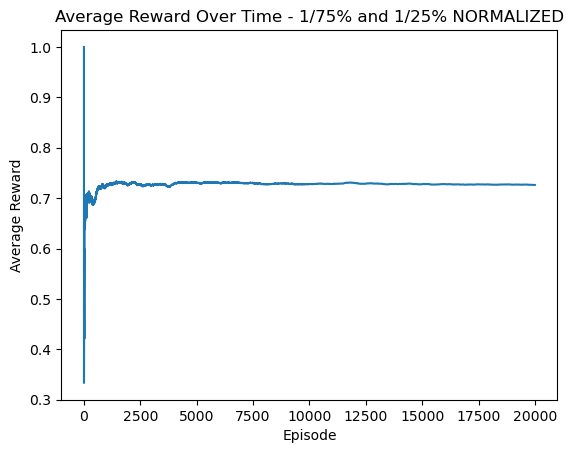

In [9]:
 # Rewards of 1, with 75% and 25% probability respectively

experiment = Experiment(1, 1, 75, 25)
agent = Agent()
steps = 20000

avg_rewards, q_values2_norm = train_agent(steps, experiment, agent)

# Visualization

plt.plot(avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward Over Time - 1/75% and 1/25% NORMALIZED')
plt.show()


## Implementing PPO